In [1]:
import numpy as np

from tflearn import DNN
from tflearn.layers.core import input_data, fully_connected
from tflearn.layers.estimator import regression
import tensorflow as tf
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_absolute_error

curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [2]:
LR = 0.001

In [3]:
def load_pair(directory, num1 = 32, num2 = 32, num3 = 32): # load calculation data
    density_file = directory + 'density.dx'
    vxc_file = directory + 'vxc.dx'
    density = np.genfromtxt(density_file, skip_header = 7, max_rows = num1*num2*num3, dtype = np.float64)
    vxc = np.genfromtxt(vxc_file, skip_header = 7, max_rows = num1*num2*num3, dtype = np.float64)
    density = np.reshape(density, (num1, num2, num3))
    vxc = np.reshape(vxc, (num1, num2, num3))
    return density, vxc, density_file, vxc_file

def plot_slice(array, idx, a, b, Nx, Ny, blue = 1, axis = 2, num1 = 32, num2 = 32, num3 = 32):
    if axis == 0:
        slice_ = array[idx, :, :]
    if axis == 1:
        slice_ = array[:, idx, :]
    if axis == 2:
        slice_ = array[:, :, idx]
    dx = (b-a)/(Nx - 1)
    dy = (b-a)/(Ny - 1)
    x = np.zeros(Nx)
    y = np.zeros(Ny)
    for i in range(Nx):
        x[i] = a+i*dx
    for j in range(Ny):
        y[j] = a+j*dy
    X, Y = np.meshgrid(x, y)
    hf = plt.figure(figsize=(10,10))
    ha = hf.add_subplot(111, projection='3d')
    if blue == 0:
        ha.plot_surface(X, Y, slice_, color = 'r')
    else:
        ha.plot_surface(X, Y, slice_)
    plt.show()

def build_model(n_1, n_2, n_3):   # build computational graph
    network = input_data(shape=(None, n_1*n_2*n_3), name = 'input')
    network = fully_connected(network, 1000, activation = 'relu')
    network = fully_connected(network, 500, activation = 'relu')
    network = fully_connected(network, 1, activation = 'linear')

    return regression(network, optimizer='adam',
                      loss='mean_square', learning_rate=LR, name = 'targets')

    
def predict_gga(inp, rotate_type = 0): # input = 3D density array, output = 3D Vxc potential
    a = inp.shape[0]
    b = inp.shape[1]
    c = inp.shape[2]
    result_prediction = np.zeros((a,b,c))
    for i in range(a):
        for k in range(b):
            for l in range(c):
                indices1 = range(i-2,i+3)
                indices2 = range(k-2,k+3)
                indices3 = range(l-2,l+3)
                neighbourhood = inp.take(indices1, axis = 0, mode='wrap')
                neighbourhood = neighbourhood.take(indices2, axis = 1, mode='wrap')
                neighbourhood = neighbourhood.take(indices3, axis = 2, mode='wrap')
                if rotate_type == 0:
                    neighbourhood_final = neighbourhood
                if rotate_type == 1:
                    neighbourhood_final = np.rot90(neighbourhood, 1, (0,1))
                if rotate_type == 2:
                    neighbourhood_final = np.rot90(neighbourhood, 1, (1,2))
                result_prediction[i,k,l] = model_gga.predict(np.reshape(neighbourhood_final, (1, -1)))
    return result_prediction

def predict_lda(inp): # input = 3D density array, output = 3D Vxc potential
    a = inp.shape[0]
    b = inp.shape[1]
    c = inp.shape[2]
    result_prediction = np.zeros((a,b,c))
    for i in range(a):
        for k in range(b):
            for l in range(c):
                result_prediction[i,k,l] = model_lda.predict(np.reshape(inp[i,k,l], (-1, 1)))
    return result_prediction

In [4]:
# load calculation data
density_benzene_gga, vxc_benzene_gga, dfilename_benzene_gga, vxcfilename_benzene_gga = load_pair('./benzene_calculation_gga/', num1 = 44, num2 = 44, num3 = 44)
density_benzene_lda, vxc_benzene_lda, dfilename_benzene_lda, vxcfilename_benzene_lda = load_pair('./benzene_calculation_lda/', num1 = 44, num2 = 44, num3 = 44)

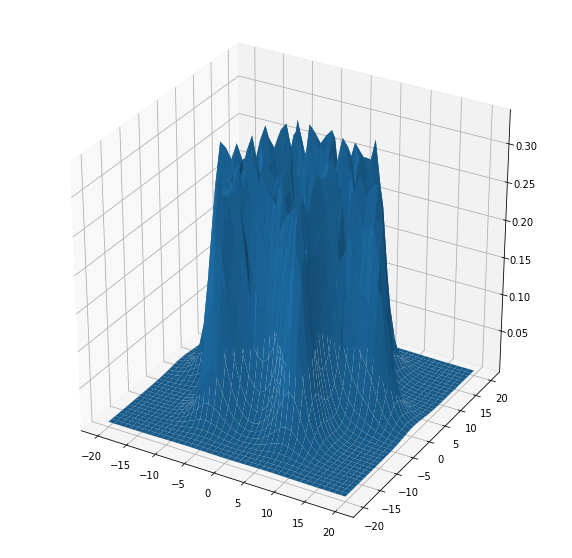

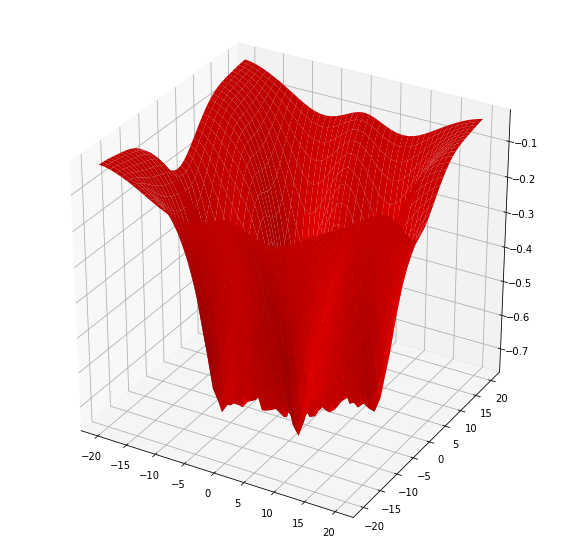

In [5]:
# plot reference data for LDA
plot_slice(density_benzene_lda, 22, -20, 20, 44, 44, blue = 1, num1 = 44, num2 = 44, num3 = 44)
plot_slice(vxc_benzene_lda, 22, -20, 20, 44, 44, blue = 0, num1 = 44, num2 = 44, num3 = 44)

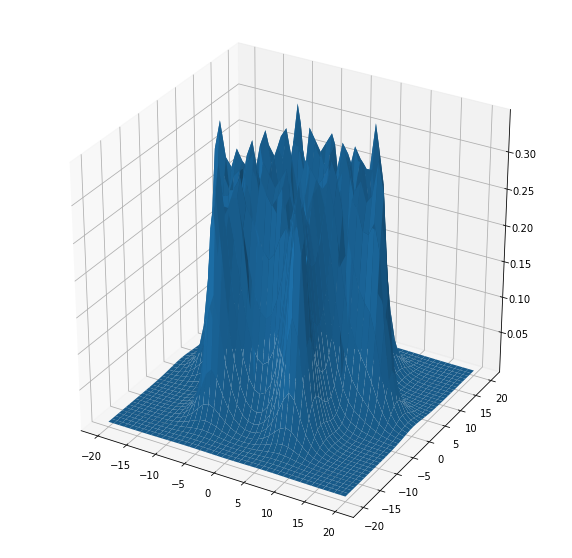

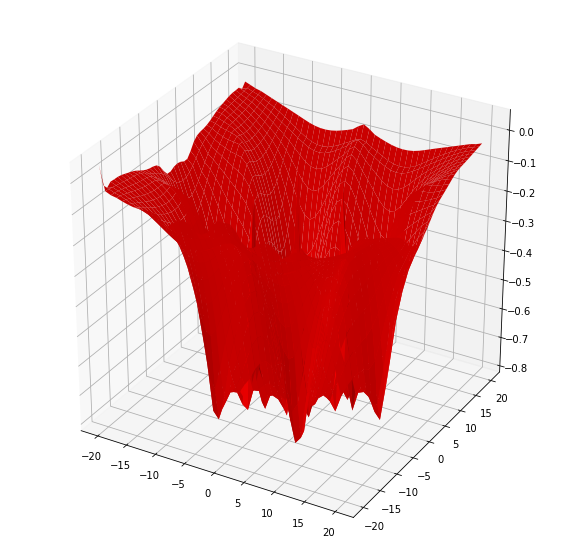

In [6]:
# plot reference data for GGA
plot_slice(density_benzene_gga, 22, -20, 20, 44, 44, blue = 1, num1 = 44, num2 = 44, num3 = 44)
plot_slice(vxc_benzene_gga, 22, -20, 20, 44, 44, blue = 0, num1 = 44, num2 = 44, num3 = 44)

In [ ]:
tf.reset_default_graph()
# Build LDA NN
lda_network = build_model(1,1,1)
model_lda = DNN(lda_network, tensorboard_verbose=0)
# Load LDA model from file
model_lda.load('lda_model')

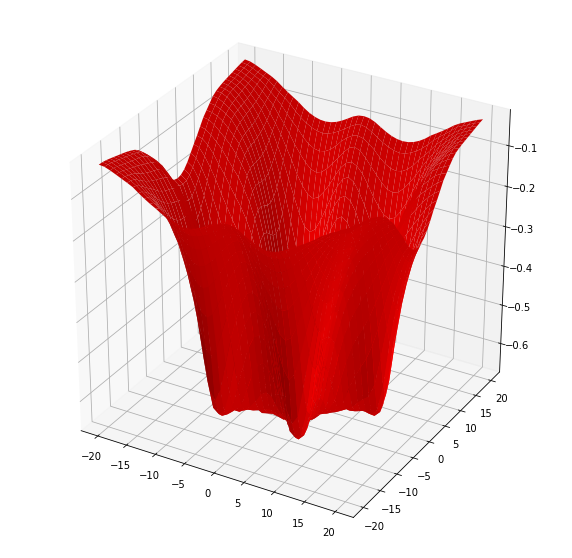

In [8]:
# predict with LDA NN
vxc_predicted_benzene_lda = predict_lda(np.log10(density_benzene_lda))
plot_slice(vxc_predicted_benzene_lda, 22, -20, 20, 44, 44, blue = 0, num1 = 44, num2 = 44, num3 = 44)

In [10]:
# Compute LDA MAE
print(mean_absolute_error(np.reshape(vxc_predicted_benzene_lda, (44*44*44)), np.reshape(vxc_benzene_lda, (44*44*44))))

0.0013563818264157638


In [ ]:
tf.reset_default_graph()
# Build GGA NN
gga_network = build_model(5,5,5)
model_gga = DNN(gga_network, tensorboard_verbose=0)
# load GGA model from file
model_gga.load('gga_model')

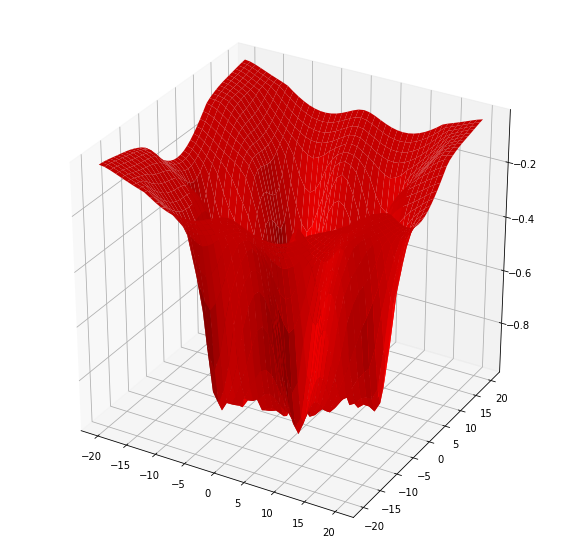

In [12]:
# predict with GGA NN
vxc_predicted_benzene_gga = predict_gga(np.log10(density_benzene_gga))
plot_slice(vxc_predicted_benzene_gga, 22, -20, 20, 44, 44, blue = 0, num1 = 44, num2 = 44, num3 = 44)

In [13]:
# Compute GGA MAE
print(mean_absolute_error(np.reshape(vxc_predicted_benzene_gga, (44*44*44)), np.reshape(vxc_benzene_gga, (44*44*44))))

0.018320075689809635
